In this notebook we'll use PyTorch to build a multiclass classification model to predict wine quality based on a couple physicochemical features of wine.

# Data Preparation

The analysis will be based on the 'Wine Quality Dataset' dataset available on kaggle.com - https://www.kaggle.com/datasets/yasserh/wine-quality-dataset. The datasets is related to red variants of the Portuguese "Vinho Verde" wine.

This dataset consists of 1143 records containing information on particular samples, regarding 11 physicochemical features like acidity, various chemicals, density, pH and so on. Detailed information on each feature is included below.

Let's import the libraries we need:

In [1426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

Let's download and view the data:

In [1427]:
path = r'WineQT.csv'
df = pd.read_csv(path)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


As this is multiclass classification, there should be more than two labels. Let's see how many there are:

In [1428]:
df['quality'].value_counts()

,count
quality,
5,483
6,462
7,143
4,33
8,16
3,6


According to the dataset's description, the target class, which is quality, is an integer value between 0 and 10. As we can see, not all classes are represented in the dataset. The worst wines' quality is 3, the best wines' quality is 7.

The dataset is not balanced. The classes are not represented evenly. There are mostly wines of quality 5, 6 or 7. There aren't many of other qualities, so, to keep things simple, let's focus on just these three qualities and keep only them:

In [1429]:
df = df[df['quality'].isin([5, 6, 7])]
df['quality'].value_counts()

,count
quality,
5,483
6,462
7,143


## Data Description

Let's look at basic information about the data:

In [1430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1088 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1088 non-null   float64
 1   volatile acidity      1088 non-null   float64
 2   citric acid           1088 non-null   float64
 3   residual sugar        1088 non-null   float64
 4   chlorides             1088 non-null   float64
 5   free sulfur dioxide   1088 non-null   float64
 6   total sulfur dioxide  1088 non-null   float64
 7   density               1088 non-null   float64
 8   pH                    1088 non-null   float64
 9   sulphates             1088 non-null   float64
 10  alcohol               1088 non-null   float64
 11  quality               1088 non-null   int64  
 12  Id                    1088 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 119.0 KB


The DataFrame consists of 1088 rows, each of which represents a single wine sample, and 13 columns, each of which represents a single feature.

The data is complete, there are no missing values. All columns are numerical (of type float64 or int64 in case of the last two columns).

Let's have a look at the features:

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality
- Id

The penultimate column, quality, serves as the target variable for prediction.

## Data Preprocessing and Cleaning

### Removing Redundant Rows and Columns

There is one column that we don't need, id, so let's remove it:

In [1431]:
df = df.drop('Id', axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We already removed the rows with wines of qualities other than 5, 6 or 7. There are no more rows to remove for now.

### Missing Data

There is no missing data:

In [1432]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


### Duplicates

Let's check for duplicates:

In [1433]:
df.duplicated().any()

True

Turns out, there are some duplicates. Let's see how many:

In [1434]:
df.duplicated().value_counts()

,count
False,964
True,124


There are 964 unique rows and 124 duplicated ones. Let's remove the duplicates:

In [1435]:
df = df.drop_duplicates()

Let's see how the particular classes are represented now:

In [1436]:
df['quality'].value_counts()

,count
quality,
5,433
6,409
7,122


There is no big difference.

### Data Transformations

As we can see, the quality values are between 5 and 7. Let's modify them to be between 0 and 2:

In [1437]:
df['quality'] = df['quality'] - 5
df['quality'].value_counts()

,count
quality,
0,433
1,409
2,122


## A Statistical Summary of the Numeric Features

Let's have a look at a statistical summary of the numeric features for the entire dataset:

In [1438]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000
mean,8.297822,0.527438,0.270239,2.520176,0.087078,15.787863,46.907158,0.996714,3.309471,0.656307,10.439678,0.677386
std,1.735466,0.175507,0.193772,1.318285,0.046482,10.180580,33.372157,0.001910,0.154273,0.162018,1.078927,0.687122
min,4.900000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.390000,8.400000,0.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.255000,2.200000,0.079000,14.000000,38.000000,0.996680,3.310000,0.620000,10.200000,1.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997842,3.400000,0.720000,11.100000,1.000000
max,15.900000,1.330000,0.790000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,1.950000,14.900000,2.000000


If you're familiar with the domain of the analysis, you will be able to tell whether the statistical values are reasonable or not. We can also check the outliers to see if there are any.

## Outliers

Let's check if there are any outliers:

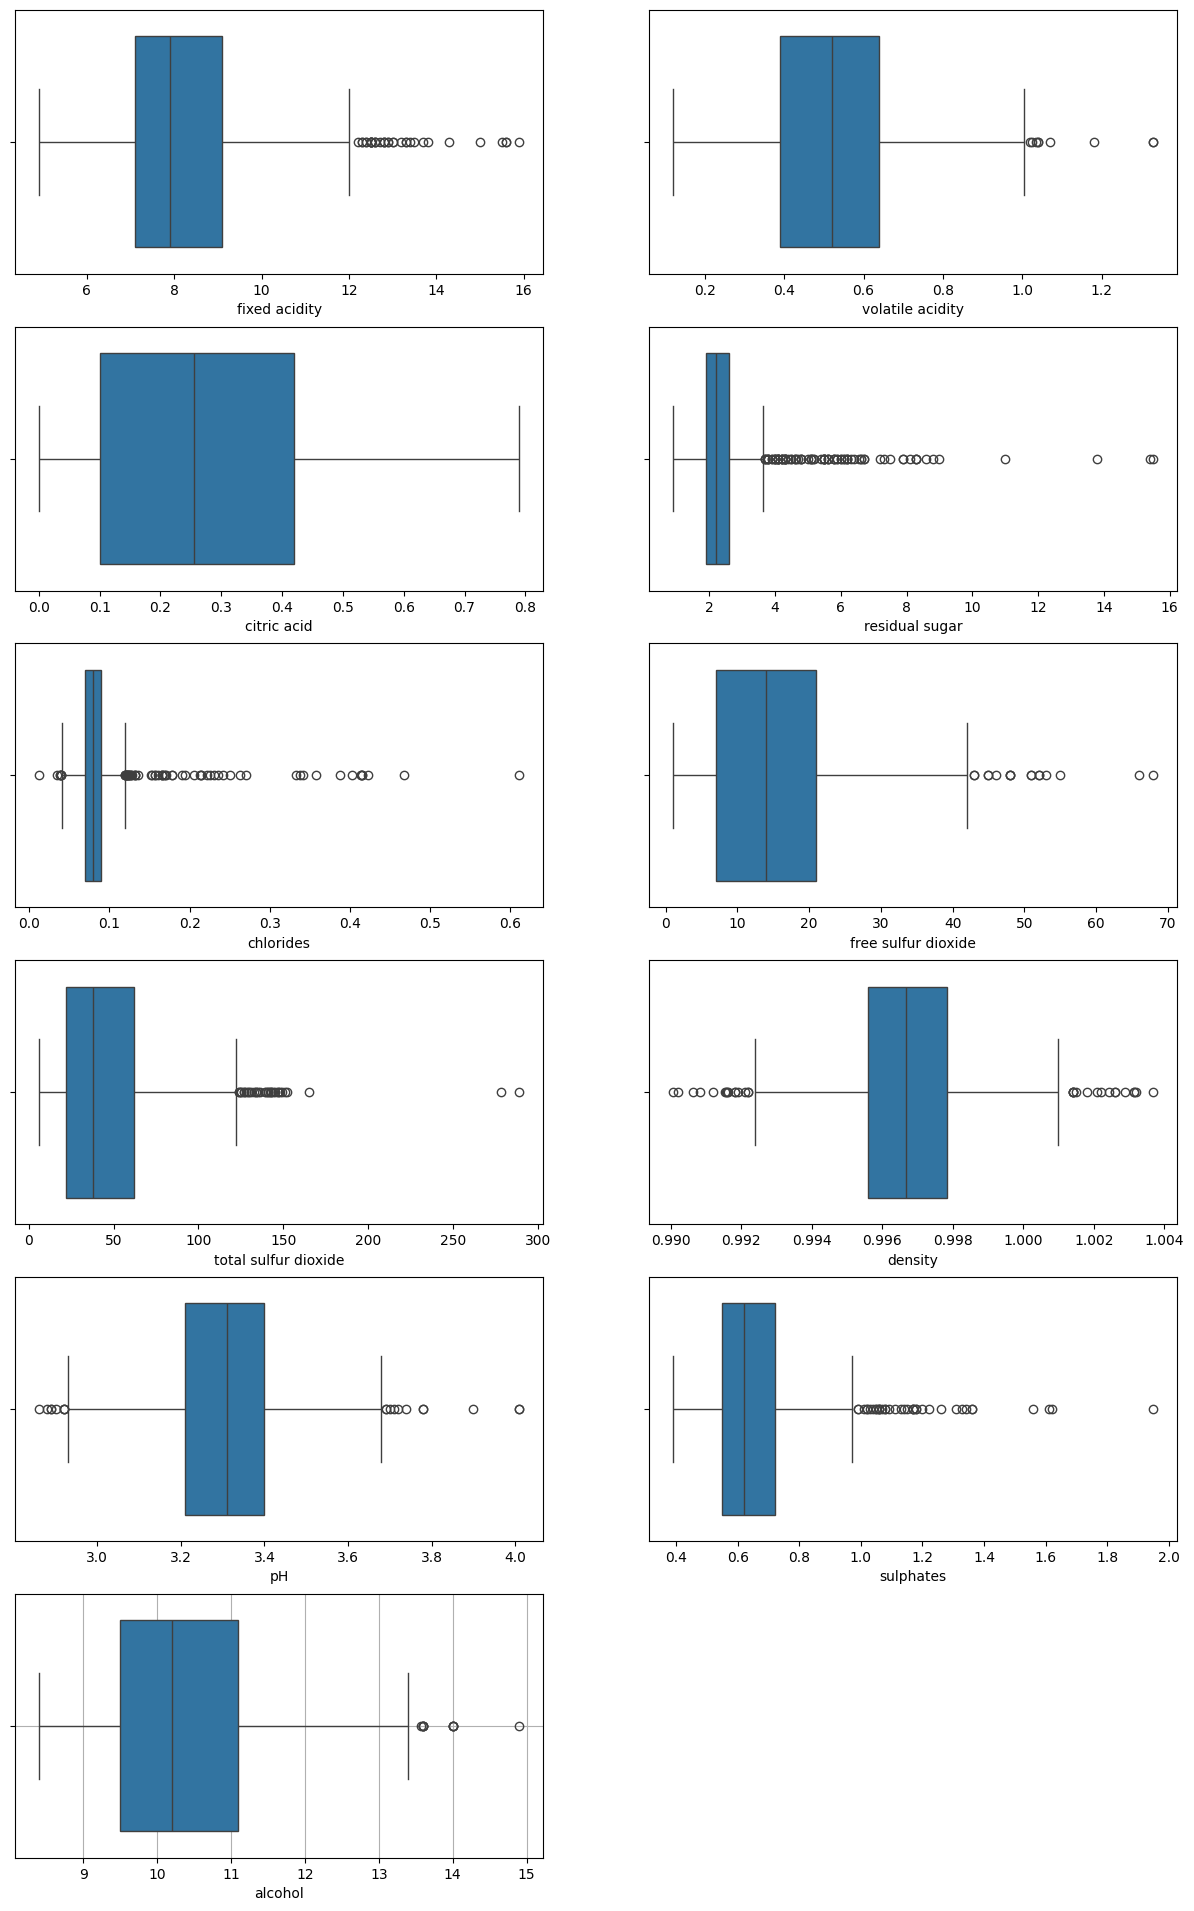

In [1439]:
plt.figure(figsize=(15, 24))
plt.subplot(6, 2, 1)
sns.boxplot(data=df, x=df["fixed acidity"], orient="h")
plt.subplot(6, 2, 2)
sns.boxplot(data=df, x=df["volatile acidity"], orient="h")
plt.subplot(6, 2, 3)
sns.boxplot(data=df, x=df["citric acid"], orient="h")
plt.subplot(6, 2, 4)
sns.boxplot(data=df, x=df["residual sugar"], orient="h")
plt.subplot(6, 2, 5)
sns.boxplot(data=df, x=df["chlorides"], orient="h")
plt.subplot(6, 2, 6)
sns.boxplot(data=df, x=df["free sulfur dioxide"], orient="h")
plt.subplot(6, 2, 7)
sns.boxplot(data=df, x=df["total sulfur dioxide"], orient="h")
plt.subplot(6, 2, 8)
sns.boxplot(data=df, x=df["density"], orient="h")
plt.subplot(6, 2, 9)
sns.boxplot(data=df, x=df["pH"], orient="h")
plt.subplot(6, 2, 10)
sns.boxplot(data=df, x=df["sulphates"], orient="h")
plt.subplot(6, 2, 11)
sns.boxplot(data=df, x=df["alcohol"], orient="h")
plt.grid()

There are quite a few outliers. We could remove some of them or even all, but let's keep them and see how the model will handle them. We can treat them as noise that will reduce the probability of overfitting.

## Data Visualization

Let's visualize the data to get a deeper insight.

### Correlations Between Features

Let's have a look at the relationships between the particular features. In particular, we're interested in how the features correlate with the target feature, which is quality.

Let's plot the pairwise relationships between the features first:

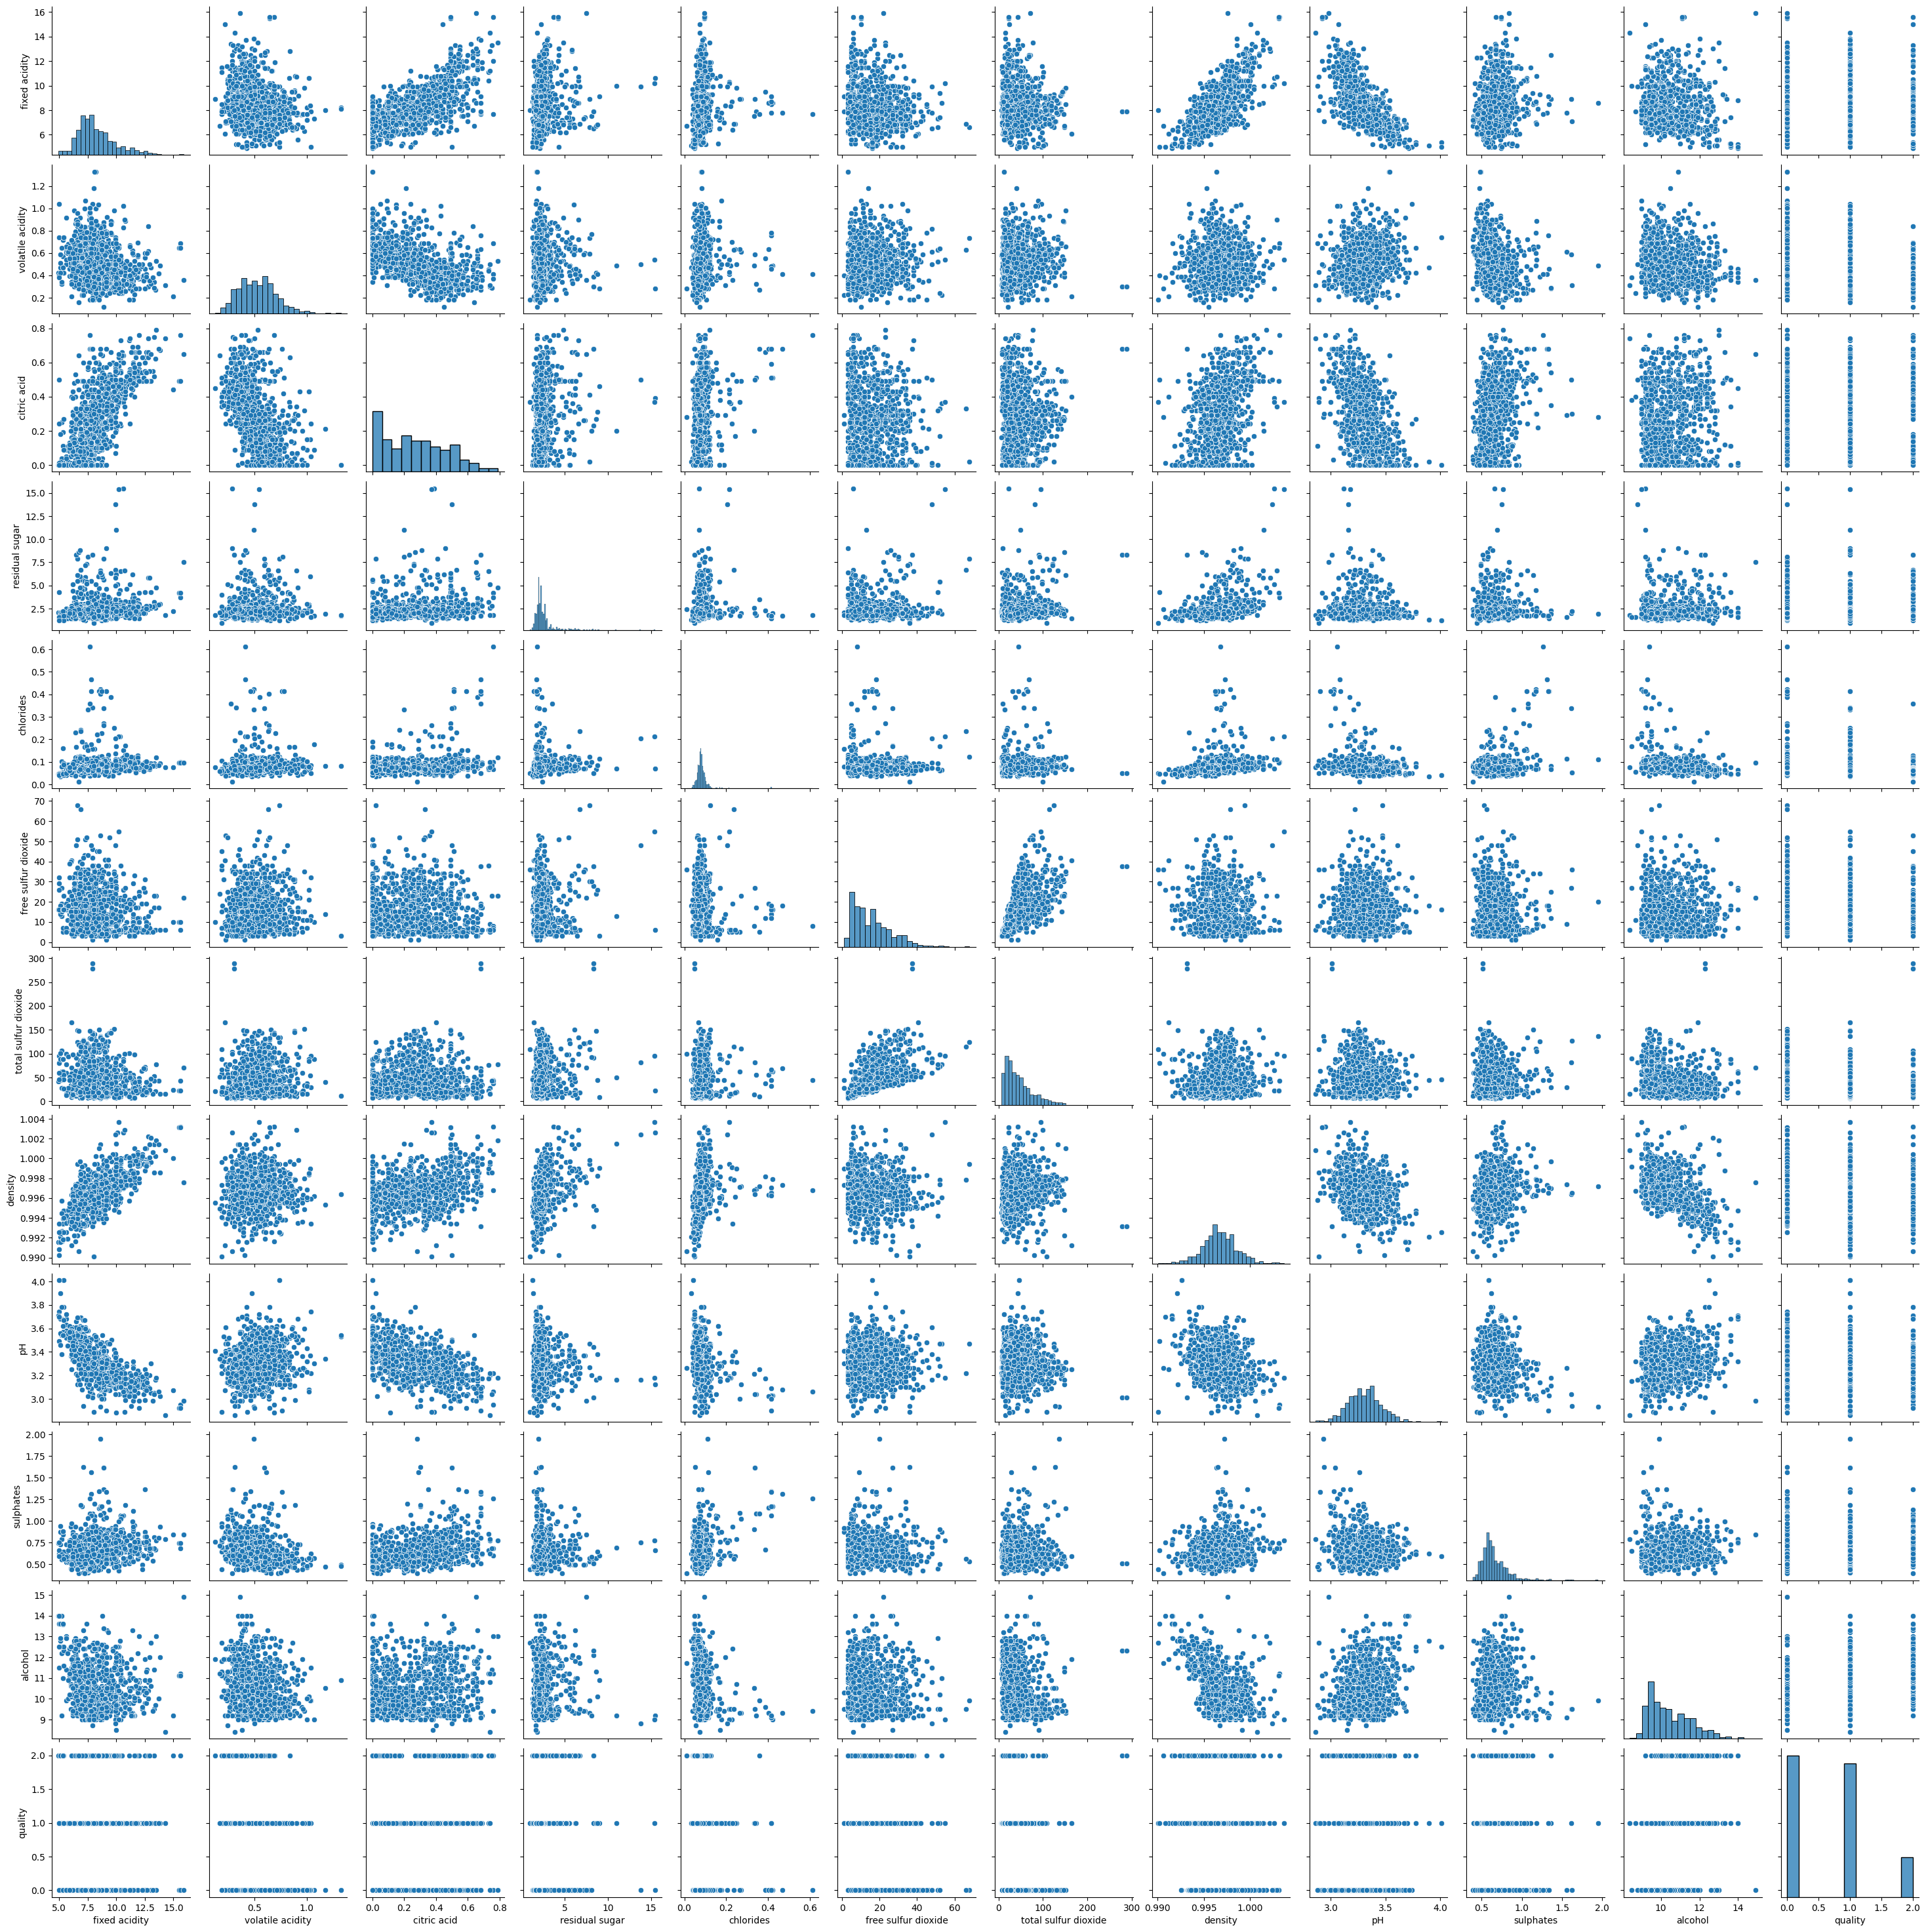

In [1440]:
sns.pairplot(df)
plt.show()

Next, let's check the correlations between the features:

In [1441]:
df_corr = df.corr()
df_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.229069,0.667855,0.171854,0.094720,-0.161890,-0.104520,0.683947,-0.690692,0.185067,-0.066098,0.112267
volatile acidity,-0.229069,1.000000,-0.533900,-0.002969,0.061430,0.004586,0.087090,0.036939,0.197129,-0.274518,-0.219454,-0.367440
citric acid,0.667855,-0.533900,1.000000,0.177139,0.224630,-0.062586,0.044014,0.371448,-0.539392,0.328471,0.102997,0.210845
residual sugar,0.171854,-0.002969,0.177139,1.000000,0.057221,0.160722,0.204066,0.368560,-0.123774,0.006147,0.055902,0.028688
chlorides,0.094720,0.061430,0.224630,0.057221,1.000000,-0.005136,0.039766,0.201048,-0.261370,0.350051,-0.237414,-0.116714
free sulfur dioxide,-0.161890,0.004586,-0.062586,0.160722,-0.005136,1.000000,0.658900,-0.053394,0.060564,0.016375,-0.054933,-0.091439
total sulfur dioxide,-0.104520,0.087090,0.044014,0.204066,0.039766,0.658900,1.000000,0.050675,-0.073194,-0.010455,-0.200326,-0.230518
density,0.683947,0.036939,0.371448,0.368560,0.201048,-0.053394,0.050675,1.000000,-0.361959,0.136982,-0.500754,-0.186010
pH,-0.690692,0.197129,-0.539392,-0.123774,-0.261370,0.060564,-0.073194,-0.361959,1.000000,-0.159241,0.224860,-0.000240
sulphates,0.185067,-0.274518,0.328471,0.006147,0.350051,0.016375,-0.010455,0.136982,-0.159241,1.000000,0.106042,0.268373


There are both positive and negative correlations. Let's create a correlation matrix:

<Axes: title={'center': 'Correlation Matrix'}>

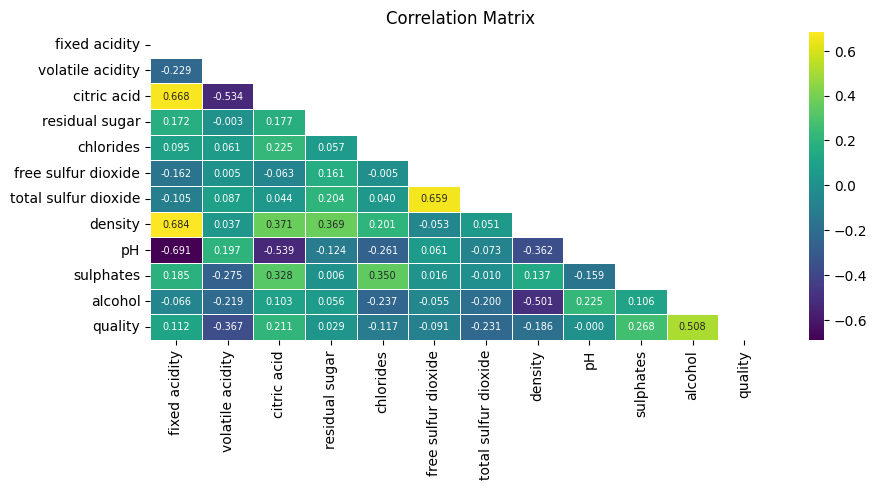

In [1442]:
mask = np.triu(df_corr)
plt.figure(figsize = (10, 4))
plt.title("Correlation Matrix")
sns.heatmap(df_corr,
            cmap = 'viridis',
            annot = True,
            annot_kws={"size": 7},
            mask = mask, linecolor = 'white',
            linewidth = .5,
            fmt = '.3f')

The feature we want to examine the correlations with is quality. The strongest positive correlation is with alcohol. The strongest negative correlation is with volatile acidity. Some correlations with other features are pretty weak (with absolute values below 0.1), so let's remove these features:

In [1443]:
columns_to_drop = ['residual sugar', 'free sulfur dioxide', 'pH']
df = df.drop(columns_to_drop, axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,0
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,1
5,7.4,0.66,0.00,0.075,40.0,0.9978,0.56,9.4,0


### Quantitative Analysis of the Features

Let's create a set of histograms for all numeric features:

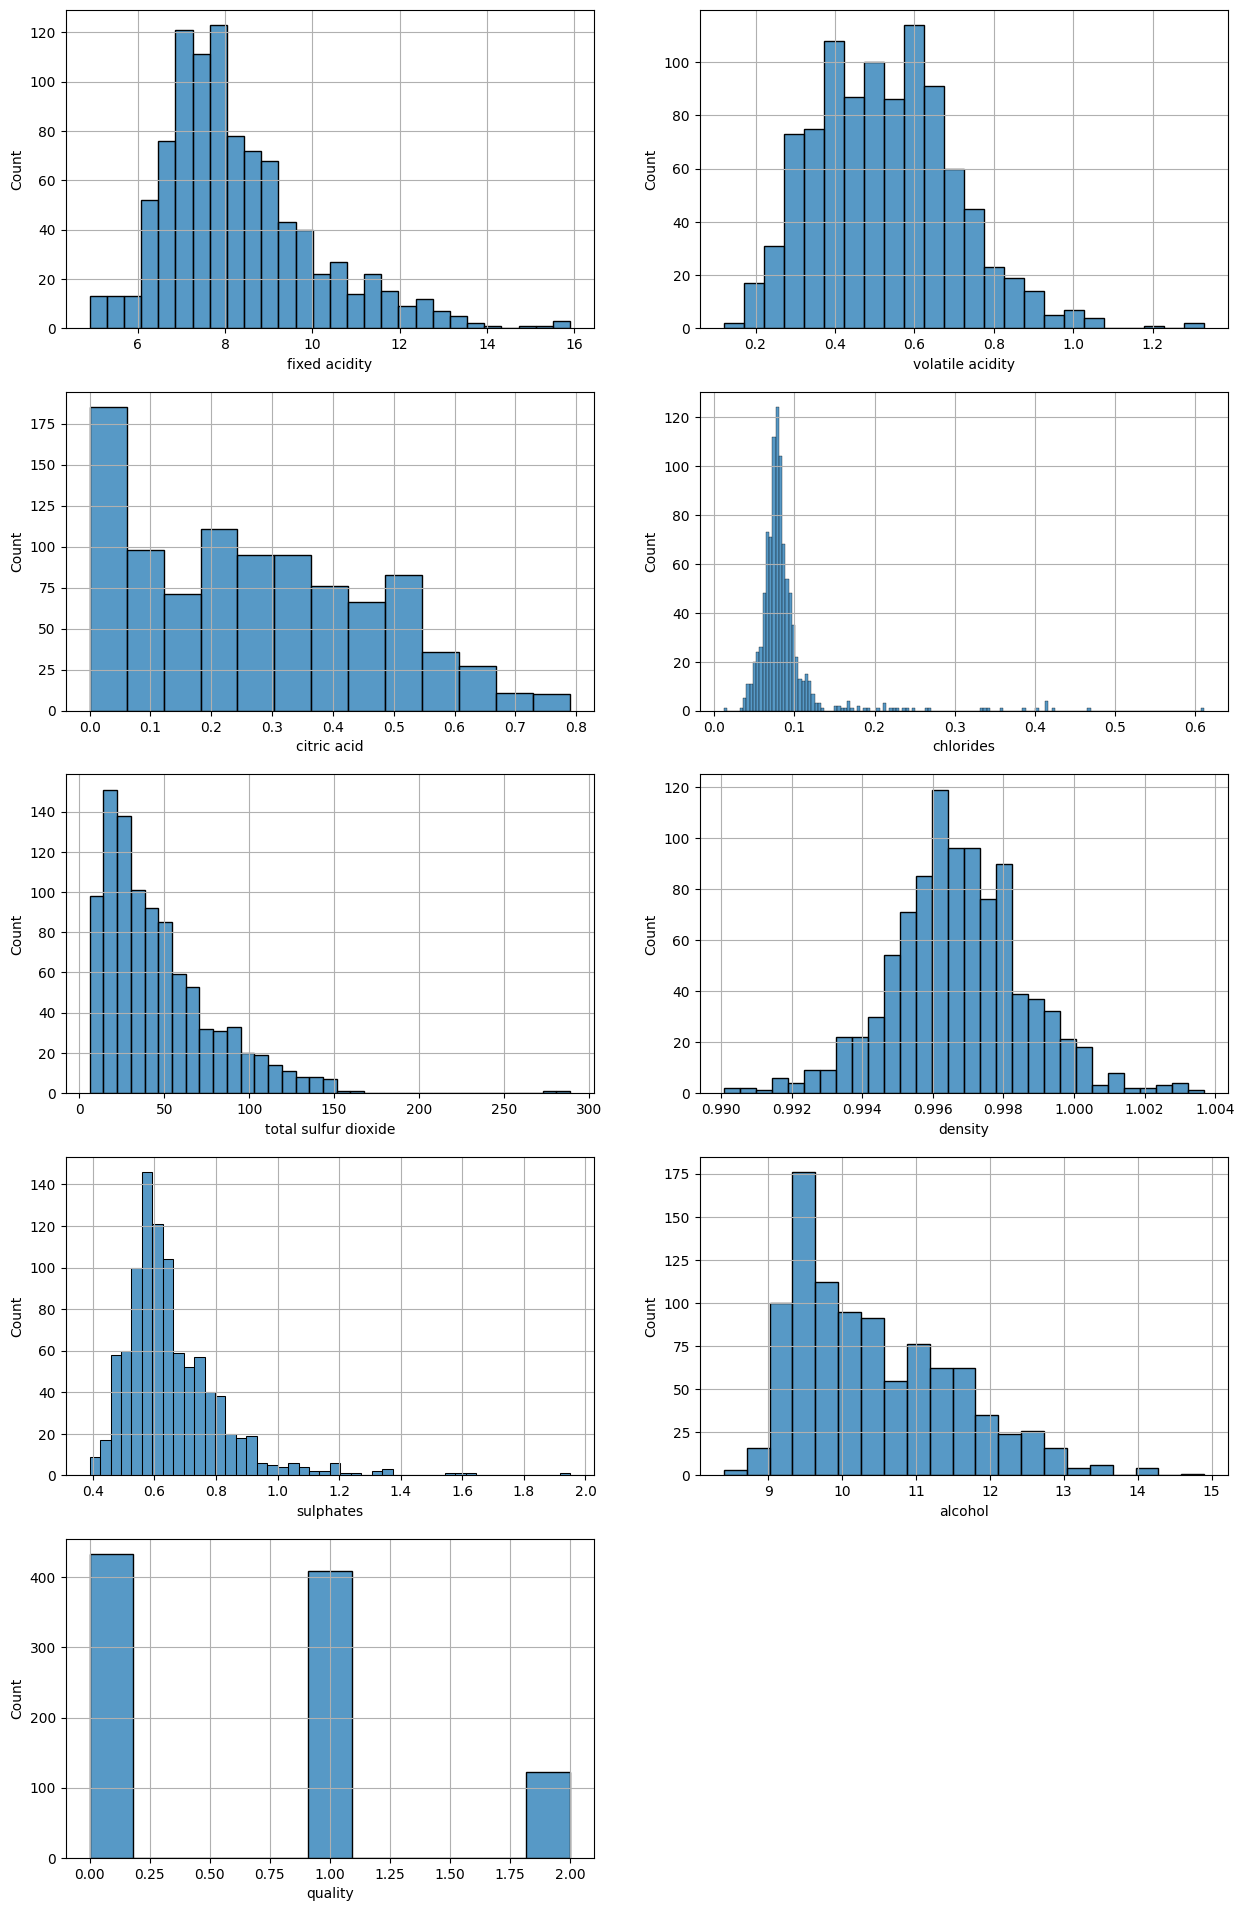

In [1444]:
plt.figure(figsize = (15, 24))

for i in range(len(df.columns)):
    plt.subplot(5, 2, i+1)
    sns.histplot(df.iloc[:, i]).set(ylabel='Count')
    plt.grid()

## Inputs and Outputs

The target feature, quality, is our output. The other features are our inputs:

In [1445]:
X = df.drop('quality', axis=1)
y = df['quality']

Let's check the input and output shapes:

In [1446]:
X.shape, y.shape

((964, 8), (964,))

So, there are 964 records. This is what the first dimension tells us. The second dimension for X means it has 8 features (vector) whereas y has a single feature (scalar). We have 8 inputs for 1 output.

## Training Set and Test Set

Before we build our model, we should split the data into two separate sets, a training set and a test set:

In [1447]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(771, 193, 771, 193)

We have 771 training samples and 193 testing samples. Now we can start building the model.

## Data Scaling

The features are in different scales. Let's have a look:

In [1448]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol
228,9.6,0.77,0.12,0.082,74.0,0.99865,0.64,10.4
361,13.3,0.29,0.75,0.084,43.0,0.99860,0.68,11.4
866,7.5,0.58,0.03,0.080,46.0,0.99592,0.47,9.2
828,9.7,0.42,0.46,0.074,16.0,0.99649,0.74,12.3
653,8.6,0.47,0.27,0.055,28.0,0.99516,0.80,11.2


For example, the values of volatile acidity are very small. The values of total sulfur dioxide are much higher, and so on. To make them more comparable, let's scale them using `StandardScaler`:

In [1449]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[:5]

array([[ 0.7187946 ,  1.37959557, -0.79819171, -0.1144161 ,  0.77849922,
         1.01075971, -0.08518684, -0.0385494 ],
       [ 2.83599167, -1.34681208,  2.44457896, -0.07216763, -0.12547289,
         0.98435383,  0.15852023,  0.89609183],
       [-0.48285779,  0.30039254, -1.26144467, -0.15666458, -0.03799172,
        -0.43100157, -1.12094192, -1.16011888],
       [ 0.77601614, -0.60841001,  0.951875  , -0.28341   , -0.91280343,
        -0.12997449,  0.52408085,  1.73726894],
       [ 0.14657918, -0.32440921, -0.02610346, -0.68477051, -0.56287875,
        -0.83237101,  0.88964146,  0.70916358]])

Now the data is rescaled in such a way that the values' mean is 0 and the standard deviation is 1.

## Tensors

PyTorch works with tensors, so we have to turn our data into tensors:

In [1450]:
import torch

X_train = torch.tensor(X_train).type(torch.float)
X_test = torch.tensor(X_test).type(torch.float)
y_train = torch.tensor(y_train.values).type(torch.int64)
y_test = torch.tensor(y_test.values).type(torch.int64)

# Let's view some samples.
X_train[:5], X_test[:5], y_train[:5], y_test[:5]

(tensor([[ 0.7188,  1.3796, -0.7982, -0.1144,  0.7785,  1.0108, -0.0852, -0.0385],
         [ 2.8360, -1.3468,  2.4446, -0.0722, -0.1255,  0.9844,  0.1585,  0.8961],
         [-0.4829,  0.3004, -1.2614, -0.1567, -0.0380, -0.4310, -1.1209, -1.1601],
         [ 0.7760, -0.6084,  0.9519, -0.2834, -0.9128, -0.1300,  0.5241,  1.7373],
         [ 0.1466, -0.3244, -0.0261, -0.6848, -0.5629, -0.8324,  0.8896,  0.7092]]),
 tensor([[-1.9134, -0.8356, -1.3644, -0.8326,  0.3703, -3.1138,  0.5850,  3.3262],
         [ 0.8905, -0.1540,  1.1578,  2.4839,  1.0118,  3.0018,  0.5850, -1.5340],
         [-0.6545,  0.9536, -0.7467, -0.2412, -0.7962, -0.6739, -0.6945, -0.3189],
         [-0.4829, -0.8356,  1.5181,  0.3926, -1.0294, -0.3623, -0.6335,  0.8961],
         [-0.4256,  1.4364, -1.4159, -0.2412, -0.0672, -0.3254, -0.2070,  0.2418]]),
 tensor([1, 2, 0, 1, 0]),
 tensor([1, 0, 0, 1, 1]))

# Model Building

We have the data in place, it's time to build a model. Besides the model, we'll define a loss function and optimizer.

But before that, let's make our code device agnostic. This is not strictly necessary for such a small dataset as ours, but it's good practice. This way, we'll make use of GPU if it's available, otherwise we'll make use of CPU:

In [1451]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In Google Colab, we can change the runtime to GPU in the Runtime menu under Change runtime type. We're not going to do it here, though.

## Defining the Model

We now want to build a model that will take our inputs and produce outputs similar to our current outputs. In other words, given the features, the model will predict the labels.

There are a couple ways of approaching this in PyTorch, but we'll create the model as a class. If we create a model as a class, we almost always inherit from `nn.Module`. Then, inside the `__init__` method, we create the layers of the neural network. In our case, we need both linear and nonlinear layers. We'll use the ReLU activation function for the latter.

It's up to us how many layers we create. It depends on how much space we want to give the model to learn. In any case, we pass two arguments to the `nn.Linear` method: `in_features`, set to the number of inputs in a particular layer, and `out_features`, set to the number of outputs from a particular layer. We can set these arguments to any numbers we want. We just have to follow the following rules:

- In the first layer, we set `in_features` to the number of inputs to the model.
- In the last layer, we set `out_features` to the number of outputs from the model.
- In the hidden layers (the layers between the first and last layers), the number if `in_features` must be equal to the number of `out_features` in the preceding layer.

We also have to define a `forward` method, which will contain the forward pass computation of the model.

In order to inherit from `nn.Module` and create the layers of the neural network, we have to import `nn`:

In [1452]:
from torch import nn

And now, let's build the model:

In [1453]:
class WineQualityClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=20):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    # Here we define the method that will compute the forward pass.
    def forward(self, x):
        return self.layer_stack(x)

Let's create an instance of the model and send it to the target device:

In [1454]:
model = WineQualityClassificationModel(input_features=8, output_features=3).to(device)
model

WineQualityClassificationModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

## Loss Function and Optimizer

The loss function is used to measure how wrong your model's predictions are compared to the truth labels (the labels in the y_test set).

The optimizer instructs your model to update its internal parameters to lower the loss.

There are a lot of loss functions in PyTorch we can choose from. For multiclass classification, a common choice is Cross Entropy Loss, which we're going to use. To this end, we'll use the `torch.nn.CrossEntropyLoss` method.

There are also a lot of optimizers. Some common ones are Adam and SGD (stochastic gradient descent). Let's pick SGD. In order to do that, we'll use the `torch.optim.SGD` method.

The SGD optimizer takes two parameters:

- `params` - these are the model's parameters that we want to optimize,
- `lr` - this is the learning rate - the higher it is the faster the optimizer will update the parameters.

We must be careful with the learning rate. It should be neither too high nor too low or it will fail to work.

So, here are the loss function and the optimizer:

In [1455]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## Metrics

We'll evaluate our model using just one metric, accuracy. It's calculated as the total number of correct predictions divided by the total number of predictions. Let's define a function that will calculate accuracy for us:

In [1456]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Model Training

Training the model involves two loops: a training loop, where the model learns the relationships between the features and labels, and a testing loop, where the model is evaluated. Let's see what exactly each of the loops contains.

## Training Loop

As mentioned above, in the training loop, the model goes through the training data and learns how the features are related to the labels.

The steps inside a training loop contain:

1. Forward pass - the model performs the `forward` method on all training data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. Gradient zeroing - the optimizer's gradients are set to zero (by default, they're accumulated) so that they can be calculated from scratch for this step,
4. Backpropagation - the gradient of the loss with respect to each parameter with `requires_grad` set to `True` is calculated,
5. Gradient descent - the parameters are updated.

## Testing Loop

The testing loop consists of the following steps:

1. Forward pass - the model performs the `forward` method on all testing data,
2. Loss calculation - the model's predictions are compared to the test values to see how badly the model performs,
3. (optionally) Evaluation metrics - we can calculate metrics like accuracy, precision or recall on the test set; we're not going to do it here.

## Training the Model

Now, let's implement all these steps in the training and testing loops:

In [1457]:
# seed for reprodicibility of random values
torch.manual_seed(42)

# Train for 300 epochs.
epochs = 300

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training loop
    model.train()

    # 1. Forward pass
    y_logits = model(X_train) # raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels

    # 2. Loss and accuracy calculation
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Gradient zeroing
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()

    ### Testing loop

    # Put the model in evaluation mode.
    model.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Loss and accuracy calculation
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out information
        if epoch % 30 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.08510, Accuracy: 40.60% | Test loss: 1.06984, Test acc: 44.04%
Epoch: 30 | Loss: 0.97241, Accuracy: 53.70% | Test loss: 0.97109, Test acc: 52.85%
Epoch: 60 | Loss: 0.90906, Accuracy: 57.33% | Test loss: 0.90855, Test acc: 56.48%
Epoch: 90 | Loss: 0.84060, Accuracy: 60.05% | Test loss: 0.83386, Test acc: 62.18%
Epoch: 120 | Loss: 0.79550, Accuracy: 61.48% | Test loss: 0.77892, Test acc: 63.21%
Epoch: 150 | Loss: 0.77356, Accuracy: 62.13% | Test loss: 0.75257, Test acc: 65.28%
Epoch: 180 | Loss: 0.76128, Accuracy: 63.29% | Test loss: 0.74153, Test acc: 67.36%
Epoch: 210 | Loss: 0.75330, Accuracy: 63.68% | Test loss: 0.73706, Test acc: 66.32%
Epoch: 240 | Loss: 0.74695, Accuracy: 63.94% | Test loss: 0.73554, Test acc: 67.88%
Epoch: 270 | Loss: 0.74173, Accuracy: 64.46% | Test loss: 0.73475, Test acc: 67.88%


As you can see, the model performs pretty well, although not perfectly.

# Model Evaluation

Let's evaluate the model and see how it performs on data it never saw:

In [1458]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_test) # logits
    y_pred_probs = torch.softmax(y_logits, dim=1) # prediction probabilities
    y_preds = y_pred_probs.argmax(dim=1) # prediction labels

Let's see how the test data and the predictions compare:

In [1459]:
y_preds[:10], y_test[:10]

(tensor([2, 0, 0, 1, 1, 0, 1, 1, 0, 1]),
 tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1]))

In [1462]:
differences = (y_preds - y_test)

res = pd.DataFrame({'y_preds - y_test': differences}).value_counts()
res

,count
y_preds - y_test,
0,131
-1,41
1,21


As we can see, the model classifies most of the test data correctly. These are the cases where the difference between test data and prediction is 0.
But it's not perfect and there's definitely room for improvement.

# Conclusion

The model we created performs pretty well. It's not perfect and we could fine-tune it for better results. Although most of the test data is classified correctly, some of it isn't. Things we could try to improve it include hyperparameter tuning (different learning rates, numbers of hidden units or numbers of layers), using a different optimizer or training the model for a different number of epochs. Feel free to try it out.